In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsforecast.utils import results

sns.set_theme()

In [6]:
df = pd.read_csv("../data/rent_prices_long_imputed.csv")

In [7]:
df.head()

,areaName,Borough,areaType,Date,Value,Value_Imputed
0,All Downtown,Manhattan,submarket,2010-01-01,3200.0,3200.0
1,All Downtown,Manhattan,submarket,2010-02-01,3200.0,3200.0
2,All Downtown,Manhattan,submarket,2010-03-01,3015.0,3015.0
3,All Downtown,Manhattan,submarket,2010-04-01,3100.0,3100.0
4,All Downtown,Manhattan,submarket,2010-05-01,3100.0,3100.0


In [8]:
print(pd.unique(df["Borough"]))

['Manhattan' 'Queens' 'Brooklyn' 'Bronx' nan 'Staten Island']


There are NaN boroughs that need to be dealt with. To do that I will filter them out after figuring out what they are.

In [9]:
print(df[df["Borough"].isnull()])

      areaName Borough areaType        Date   Value  Value_Imputed
14134      NYC     NaN     city  2010-01-01  2650.0         2650.0
14135      NYC     NaN     city  2010-02-01  2600.0         2600.0
14136      NYC     NaN     city  2010-03-01  2600.0         2600.0
14137      NYC     NaN     city  2010-04-01  2650.0         2650.0
14138      NYC     NaN     city  2010-05-01  2695.0         2695.0
...        ...     ...      ...         ...     ...            ...
14320      NYC     NaN     city  2025-07-01  4040.0         4040.0
14321      NYC     NaN     city  2025-08-01  4050.0         4050.0
14322      NYC     NaN     city  2025-09-01  3995.0         3995.0
14323      NYC     NaN     city  2025-10-01  3950.0         3950.0
14324      NYC     NaN     city  2025-11-01  3875.0         3875.0

[191 rows x 6 columns]


The NaNs are the total medians of all NYC. Because of that I'm going to seperate them into two dataframes.

In [10]:
nyc_medians = df[df["Borough"].isnull()]
nyc_medians = nyc_medians.drop(["Borough", "areaType", "Value"], axis = 1)
nyc_medians = nyc_medians.rename(columns = {"Value_Imputed": "Median Price"})
nyc_medians.head()

,areaName,Date,Median Price
14134,NYC,2010-01-01,2650.0
14135,NYC,2010-02-01,2600.0
14136,NYC,2010-03-01,2600.0
14137,NYC,2010-04-01,2650.0
14138,NYC,2010-05-01,2695.0


In [11]:
neighborhood_medians = df[df["Borough"] != "NaN"].rename(columns={"Value_Imputed" : "Median Price"}).drop(["Value"], axis = 1)
neighborhood_medians.head()

,areaName,Borough,areaType,Date,Median Price
0,All Downtown,Manhattan,submarket,2010-01-01,3200.0
1,All Downtown,Manhattan,submarket,2010-02-01,3200.0
2,All Downtown,Manhattan,submarket,2010-03-01,3015.0
3,All Downtown,Manhattan,submarket,2010-04-01,3100.0
4,All Downtown,Manhattan,submarket,2010-05-01,3100.0


In [12]:
nyc_medians['Date'] = pd.to_datetime(nyc_medians['Date'])
neighborhood_medians['Date'] = pd.to_datetime(neighborhood_medians['Date'])

We can save them now for ease of use in the model creation step.

In [13]:
nyc_medians.to_csv("../data/nyc_medians.csv")
neighborhood_medians.to_csv("../data/neighborhood_medians.csv")

Now that they are saved the data will be explored before creating the model to get a better understanding of the data.

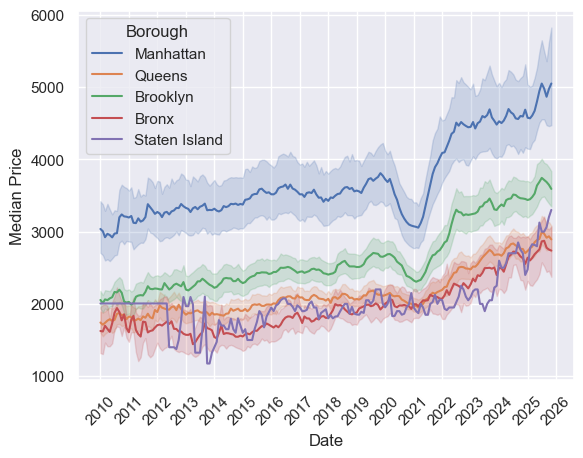

In [14]:
borough_plot = sns.lineplot(
    data = neighborhood_medians, x = "Date", y = "Median Price", hue = "Borough"
)
borough_plot.xaxis.set_major_locator(mdates.YearLocator())

borough_plot.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45)

plt.show()

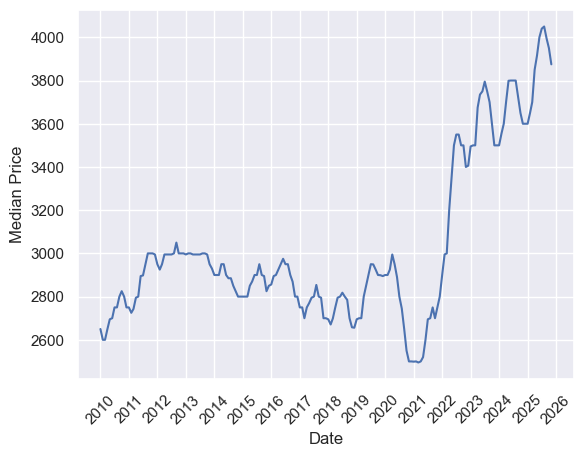

In [15]:
nyc_plot = sns.lineplot(
    data = nyc_medians, x = "Date", y = "Median Price"
)
nyc_plot.xaxis.set_major_locator(mdates.YearLocator())

nyc_plot.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45)
plt.show()

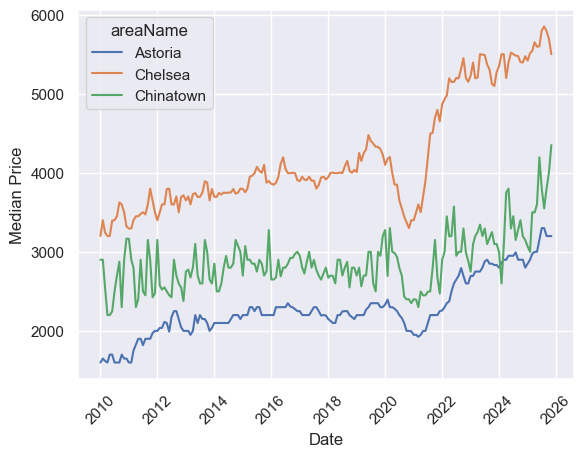

In [18]:
chinatown_plot = sns.lineplot(
    data = neighborhood_medians[neighborhood_medians['areaName'].isin(['Astoria', 'Chinatown', 'Chelsea'])], x = "Date", y = "Median Price", hue = "areaName"
)
nyc_plot.xaxis.set_major_locator(mdates.YearLocator())

nyc_plot.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45)
plt.show()

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [24]:
chinatown = neighborhood_medians[neighborhood_medians['areaName'] == 'Chinatown']
chinatown.head()

,areaName,Borough,areaType,Date,Median Price
4775,Chinatown,Manhattan,neighborhood,2010-01-01,2900.0
4776,Chinatown,Manhattan,neighborhood,2010-02-01,2900.0
4777,Chinatown,Manhattan,neighborhood,2010-03-01,2550.0
4778,Chinatown,Manhattan,neighborhood,2010-04-01,2200.0
4779,Chinatown,Manhattan,neighborhood,2010-05-01,2200.0


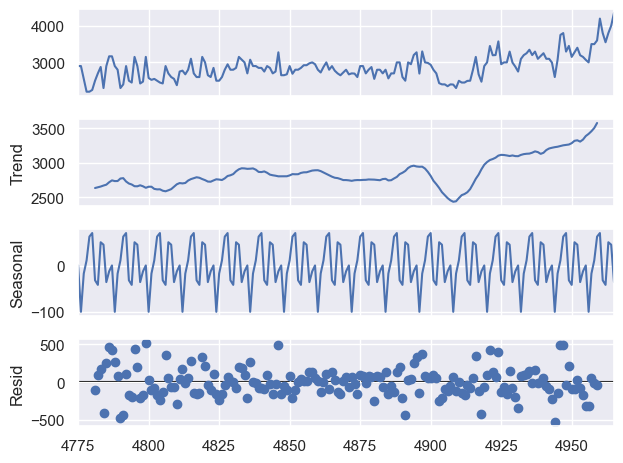

In [30]:
decomp = seasonal_decompose(chinatown[["Median Price"]].dropna(), model="additive", period=12)
decomp.plot()
plt.show()

The seasonal decomposition shows us that there is a seasonality pattern with prices fluctuating as low as $100 below the normal price. Addtionally the trend graph shows a roughly positive linear trend with a strong dip from 2020-2022 due to COVID.

Now a test SARIMAX model will be made on just the chinatown df. First a is covid column will be added which will be the exogenous regressor.

In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [51]:
chinatown = chinatown.copy()

mask = (chinatown["Date"] > "2020-03-01") & (chinatown["Date"] < "2021-11-01")
chinatown["is_covid"] = mask.astype(int)

chinatown = chinatown[["Date", "Median Price", "is_covid"]]
chinatown["Date"] = pd.to_datetime(chinatown["Date"])
chinatown = chinatown.set_index("Date")
chinatown.index.freq = "MS"

In [52]:
def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')

check_stationarity(chinatown[["Median Price"]])

ADF Statistic: -0.14008911629073678
p-value: 0.9452961946418935
Non-Stationary


Data is non-stationary which is fine because the SARIMAX model will take care of that.

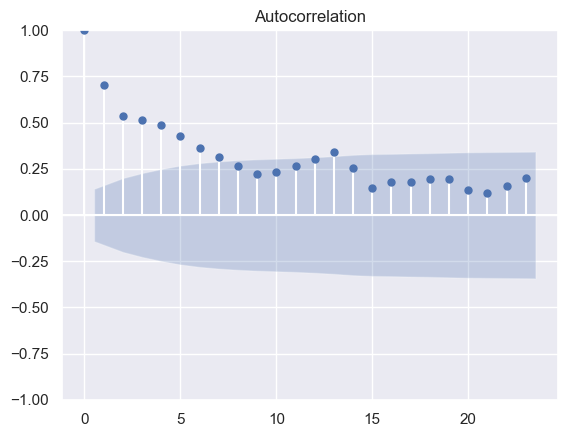

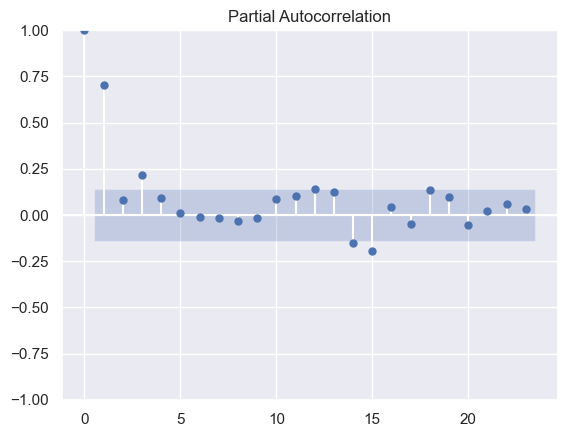

In [53]:
plot_acf(chinatown[["Median Price"]])
plot_pacf(chinatown[["Median Price"]])
plt.show()

In [54]:
chinatown.head()

,Median Price,is_covid
Date,,
2010-01-01,2900.0,0
2010-02-01,2900.0,0
2010-03-01,2550.0,0
2010-04-01,2200.0,0
2010-05-01,2200.0,0


In [80]:
model = SARIMAX(endog=chinatown["Median Price"],
                exog=chinatown[["is_covid"]],
                order=(2, 1, 0),
                seasonal_order=(1, 1, 1, 12))

results = model.fit()

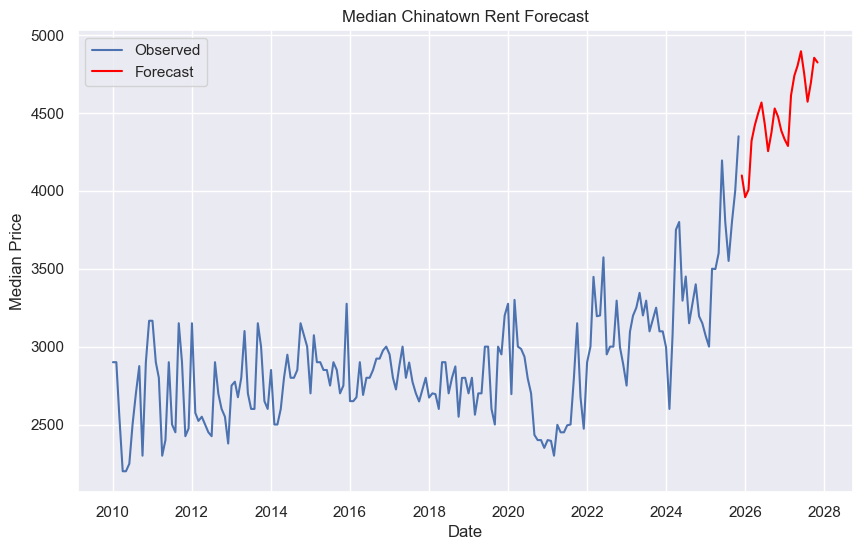

In [82]:
forecast_periods = 24
future_covid_status = [[0]] * forecast_periods

forecast = results.forecast(steps=forecast_periods, exog=future_covid_status)

plt.figure(figsize=(10, 6))

plt.plot(chinatown.index, chinatown["Median Price"], label='Observed')

plt.plot(forecast.index, forecast, label='Forecast', color='red')

plt.title("Median Chinatown Rent Forecast")
plt.xlabel("Date")
plt.ylabel("Median Price")
plt.legend()
plt.show()

In [84]:
train_data = chinatown.iloc[:-12]
test_data = chinatown.iloc[-12:]

train_exog = chinatown[["is_covid"]].iloc[:-12]
test_exog = chinatown[["is_covid"]].iloc[-12:]

print(f"Training on {len(train_data)} months.")
print(f"Testing on {len(test_data)} months.")

Training on 179 months.
Testing on 12 months.


In [130]:
def train_model(train_data, train_exog):
    new_model = SARIMAX(endog=train_data["Median Price"],
                    exog=train_exog,
                    order=(2, 1, 0),
                    seasonal_order=(1, 1, 1, 12))

    return new_model.fit()

model_fit = train_model(train_data, train_exog)

In [131]:
# 3. Forecast
# We must pass the 'test_exog' so it knows if there was Covid during the test period
predictions = model_fit.forecast(steps=len(test_data), exog=test_exog)

# Assign the correct index to predictions for plotting
predictions.index = test_data.index

In [132]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def score(actual, predicted):
    rmse = sqrt(mean_squared_error(actual["Median Price"], predicted))

    # MAPE (Mean Absolute Percentage Error) - How far off are we in %?
    mape = mean_absolute_percentage_error(actual["Median Price"], predicted)

    print(f"RMSE: ${rmse:.2f}")
    print(f"MAPE: {mape:.2%}")

score(test_data, predictions)

RMSE: $433.40
MAPE: 7.83%


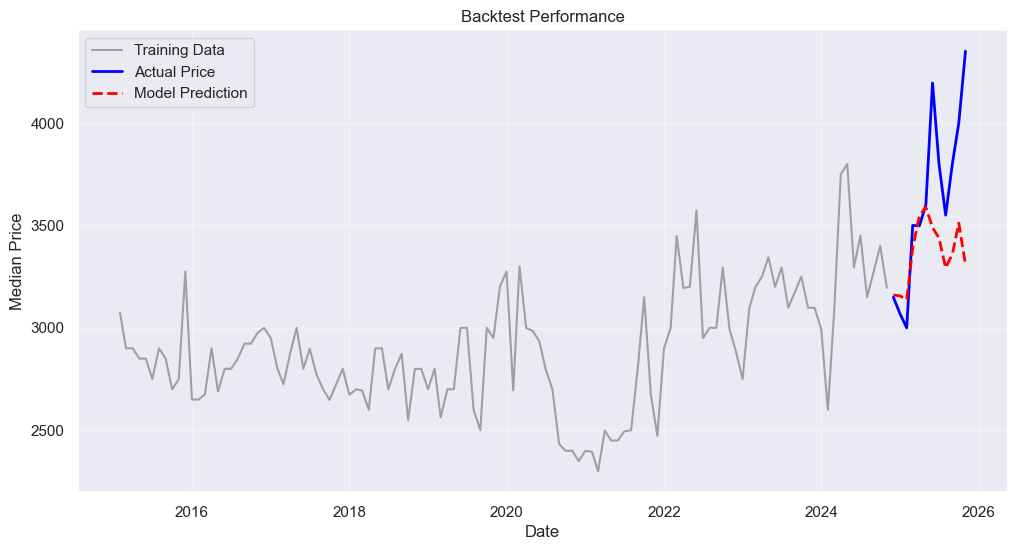

In [133]:
def plot_backtest(train_data, test_data, predictions):
    """
    Plots Training vs Test vs Predictions ensuring dates align.
    """
    plt.figure(figsize=(12, 6))

    # 1. Plot Training Data (The Past)
    plt.plot(train_data.index, train_data["Median Price"], label='Training Data', color='gray', alpha=0.7)

    # 2. Plot Test Data (The Truth)
    plt.plot(test_data.index, test_data["Median Price"], label='Actual Price', color='blue', linewidth=2)

    # 3. CRITICAL STEP: Ensure predictions share the same index as test_data
    # This forces the red line to sit exactly on top of the blue line's time period
    predictions_series = pd.Series(predictions, index=test_data.index)

    # 4. Plot Prediction
    plt.plot(predictions_series.index, predictions_series, label='Model Prediction', color='red', linestyle='--', linewidth=2)

    plt.title("Backtest Performance")
    plt.xlabel("Date")
    plt.ylabel("Median Price")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_backtest(train_data, test_data, predictions)

Initial Chinatown model isn't amazing when scoring. So a couple of methods will be used to increase accuracy. The first will be cutting of the data to
2015 and later.

In [166]:
recent_chinatown = chinatown[chinatown.index > "2015-01-01"]
train_data = recent_chinatown.iloc[:-12]
test_data = recent_chinatown.iloc[-12:]

train_exog = recent_chinatown[["is_covid"]].iloc[:-12]
test_exog = recent_chinatown[["is_covid"]].iloc[-12:]

print(f"Training on {len(train_data)} months.")
print(f"Testing on {len(test_data)} months.")

Training on 118 months.
Testing on 12 months.


In [167]:
recent_model = train_model(train_data, train_exog)
predictions = model_fit.forecast(steps=len(test_data), exog=test_exog)

predictions.index = test_data.index

In [168]:
score(train_data, recent_model.predict())

RMSE: $393.95
MAPE: 7.35%


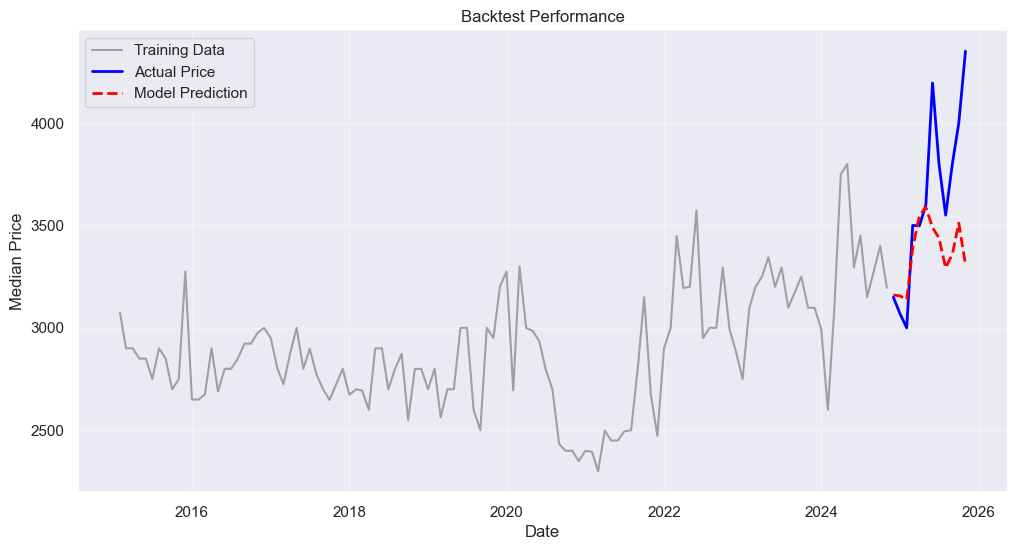

In [169]:
plot_backtest(train_data, test_data, predictions)

Now i'm going to use pmdarima to automatically calculate the parameters.

In [170]:
import pmdarima as pm

auto_model = pm.auto_arima(train_data["Median Price"],
                           exogenous=train_exog,
                           seasonal=True, m=12,
                           d=1, D=1,
                           max_p=3, max_q=3,
                           trace=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1455.018, Time=0.46 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1513.348, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1473.880, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1452.951, Time=0.08 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1488.798, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1453.881, Time=0.20 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1453.770, Time=0.30 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1461.922, Time=0.05 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1471.932, Time=0.06 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1453.855, Time=0.17 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1453.451, Time=0.20 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1462.771, Time=0.14 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=1455.166, Time=0.37 sec
 ARIMA(0,1,1)(0,1,1)[12]

In [171]:
def train_model(train_data, train_exog):
    new_model = SARIMAX(endog=train_data["Median Price"],
                    exog=train_exog,
                    order=(0, 1, 1),
                    seasonal_order=(0, 1, 1, 12))

    return new_model.fit()


In [172]:
recent_model = train_model(train_data, train_exog)
predictions = model_fit.forecast(steps=len(test_data), exog=test_exog)

predictions.index = test_data.index

In [173]:
score(train_data, recent_model.predict())

RMSE: $393.95
MAPE: 7.35%


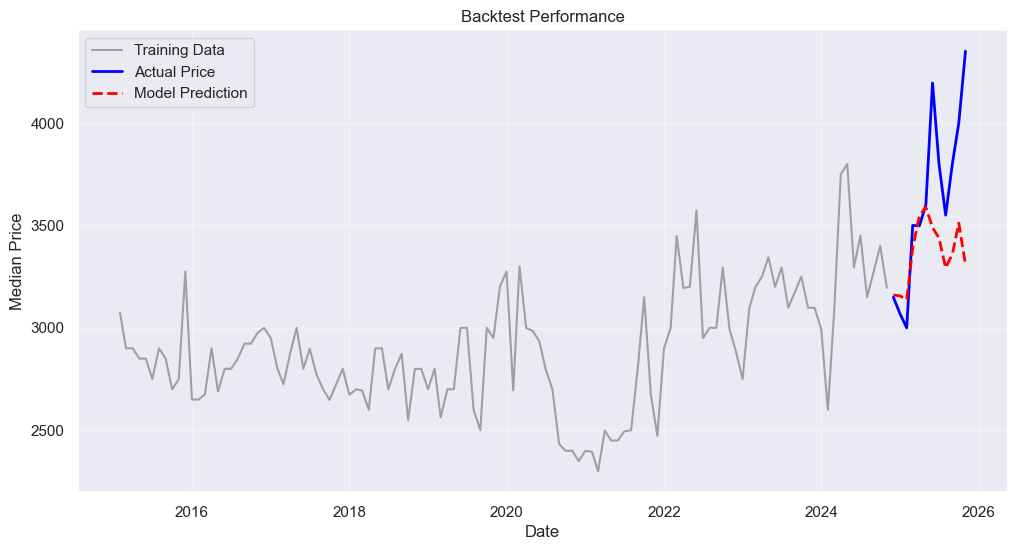

In [174]:
plot_backtest(train_data, test_data, predictions)

still isn't amazing so I'm going to perform a log on the data.

In [175]:
import numpy as np

# 1. Transform the Target to Log Scale
# This squashes the huge recent spikes, making them easier to model
train_log = np.log(train_data["Median Price"])

# 2. Train the model on the Log data
# We keep the same order for now, but the model sees a simpler curve
model_log = SARIMAX(endog=train_log,
                    exog=train_exog,
                    order=(0, 1, 1),
                    seasonal_order=(0, 1, 1, 12))
model_fit_log = model_log.fit()

# 3. Forecast (The result will be in Log units)
forecast_log = model_fit_log.forecast(steps=len(test_data), exog=test_exog)

# 4. Reverse the transformation (Log -> Real Price)
predictions_back_to_dollars = np.exp(forecast_log)

# --- Check Performance ---
rmse = sqrt(mean_squared_error(test_data["Median Price"], predictions_back_to_dollars))
print(f"New RMSE: ${rmse:.2f}")

New RMSE: $437.66


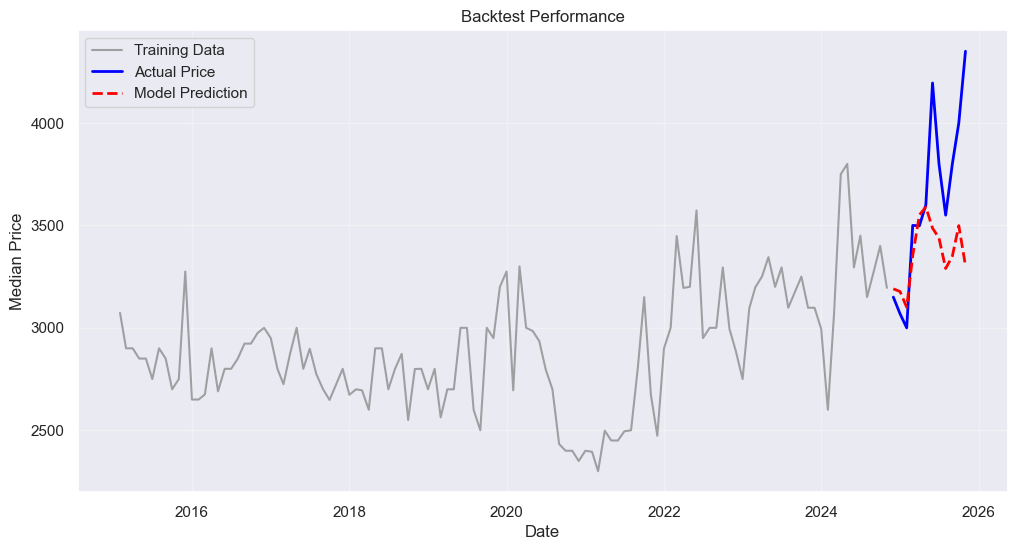

In [176]:
plot_backtest(train_data, test_data, predictions_back_to_dollars)

23:33:57 - cmdstanpy - INFO - Chain [1] start processing
23:33:57 - cmdstanpy - INFO - Chain [1] done processing


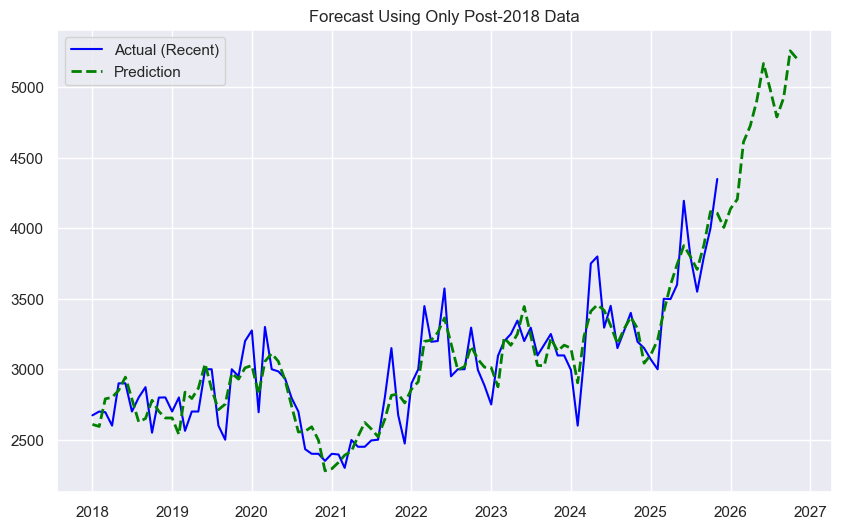

In [182]:
# 1. Slice the data to keep only the "Modern Era"
# We discard the stable years so they don't drag down the volatility predictions
recent_df = df_prophet[df_prophet['ds'] >= '2018-01-01'].copy()

# 2. Re-train the model on this smaller, more relevant dataset
m = Prophet(
    changepoint_prior_scale=1.0,     # Very flexible trend
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    changepoint_range=0.95
)
m.add_regressor('is_covid')

m.fit(recent_df)

# 3. Forecast
future = m.make_future_dataframe(periods=12, freq='MS')
future['is_covid'] = 0
# Note: You need to be careful matching the 'is_covid' length to the new short dataframe
# It's easiest to just re-merge or fill it manually based on dates
future.loc[future['ds'].isin(recent_df[recent_df['is_covid']==1]['ds']), 'is_covid'] = 1

forecast = m.predict(future)

# 4. Plot
plt.figure(figsize=(10, 6))
plt.plot(recent_df['ds'], recent_df['y'], label='Actual (Recent)', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Prediction', color='green', linestyle='--', linewidth=2)
plt.title("Forecast Using Only Post-2018 Data")
plt.legend()
plt.show()

# Rewrite code using prophet docs but for prod keep in mind when retraining to only use 2018 and up data for best results. Also try this with SARIMAX instead of Prophet too.

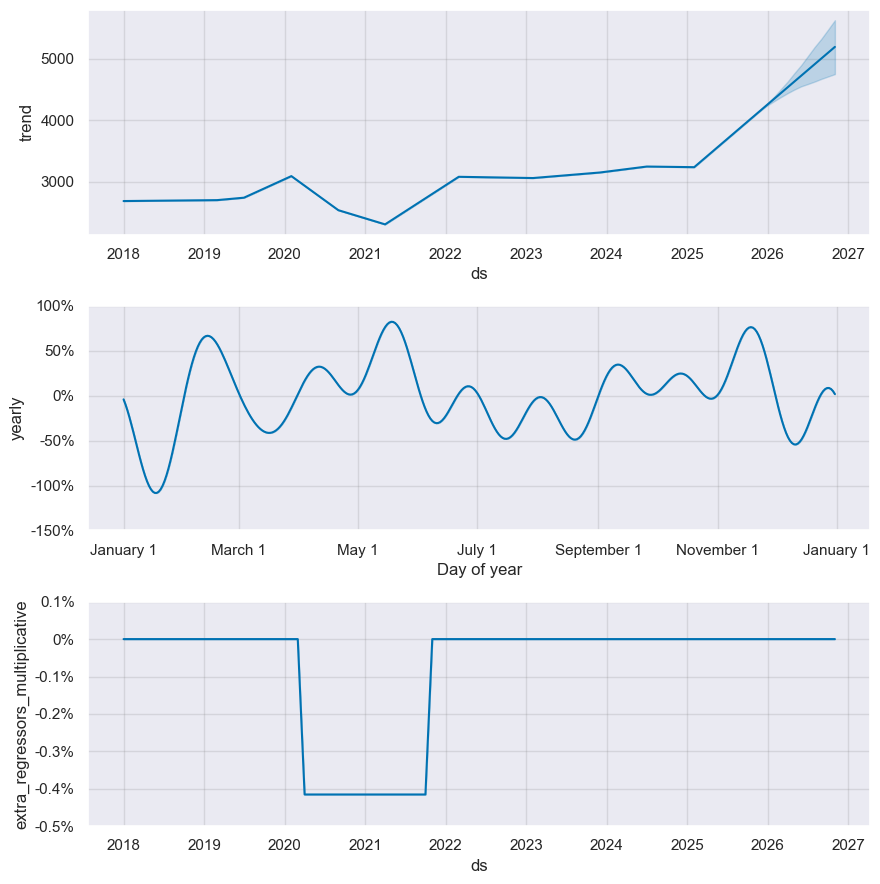

In [183]:
fig2 = m.plot_components(forecast)